
## Assignment 3: denoising with deep learning

By Aurélie Bugeau and Nicolas Papadakis 
Credits Charles Deledalle  

In this assignment,
we are going to consider a specific regression problem: image denoising.
We will be using deep Convolutional Neural Networks (CNNs) with PyTorch,
investigate DnCNN

We will be using a subsamples of images from the "Berkeley Segmentation Dataset and Benchmark" that can be found on Moodle.
_Note: if you wish to obtain better results and experiment further, you can download the whole dataset here. 
that are downloadable here \url{https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html#bsds500}_

This directory contains two sub-directories: `train` and `tes`,
which consist of 30 and 10 images, respectively, of either size $321 \times 481$
or $481 \times 321$.
While thousand to millions of images were required
for image classification, we can use a much smaller training set
for image denoising. This is because denoising each pixel of an image can
be seen as one regression problem. Hence, our training is in fact composed
of $30 \times 321 \times 481 \approx 31$ million samples.



_RECOMMENDATION: For this assignment, you may need to run your codes on GPU (either colaboratory or your laptop)_

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## 1 Creating noisy images of BSDS dataset with DataSet

Our goal is to use deep convolutional neural networks to learn the mapping $x_i \to y_i$
where $x_i$ are noisy images (our data/observations) and $y_i$ are clean images
(our labels/ground-truth).

We will consider the images of the BSDS dataset as our clean/ground-truth images: $y_i$.
For each of them, we will generate noisy versions by adding white Gaussian noise:
$x_i = y_i + w_i$ where $w_i$ is an image where each pixel is an independent realization
of a zero-mean Gaussian distribution with standard deviation $\sigma=30$.
Since images have different sizes, we will consider random crops of
size of $180 \times 180$.


### Question1 
Define the directory to store noisy images and explain the following code

In [2]:
# Define the directory to store noisy  images
import socket
import getpass

dataset_root_dir = 'dataset'#!COMPLETE path to image directory 
print('Data dir: %s' % dataset_root_dir)

#Dataset class
class NoisyBSDSDataset(td.Dataset):

    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=60):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = sorted(os.listdir(self.images_dir))
        
    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
            format(self.mode, self.image_size, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])
        clean = clean.crop([i, j, i + self.image_size[0], j + self.image_size[1]])
        transform = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        clean = transform(clean)
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
        return noisy, clean

Data dir: dataset


In [3]:
#Visualization function
def myimshow(image, ax=plt):
    image = image.detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

NoisyBSDSDataset(mode=train, image_size=(180, 180), sigma=60)
NoisyBSDSDataset(mode=test, image_size=(320, 320), sigma=60)
NoisyBSDSDataset(mode=val, image_size=(320, 320), sigma=60)


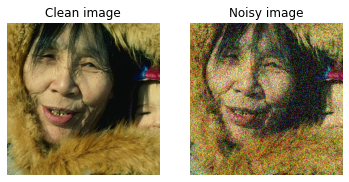

In [4]:
#Build train and test sets
train_set = NoisyBSDSDataset(dataset_root_dir, mode='train')
test_set = NoisyBSDSDataset(dataset_root_dir, mode='test', image_size=(320, 320))
val_set = NoisyBSDSDataset(dataset_root_dir, mode='val', image_size=(320, 320))
print(train_set)
print(test_set)
print(val_set)

noisy, clean = test_set[1]
fig, axes = plt.subplots(ncols=2)
myimshow(clean, ax=axes[0])
axes[0].set_title('Clean image')
myimshow(noisy, ax=axes[1])
axes[1].set_title('Noisy image')
plt.show()

## 2 DnCNN



To make our code more versatile, easy to read and save precious coding time, the architecture is going to inherit from the abstract class `NeuralNetwork` of the `nntools` package.


In [5]:
import nntools as nt

A main concept introduced in 'nntools'
is the abstract class 'NeuralNetwork'.
This class describes the general architecture and functionalities that
a neural network object is expected to have.
In particular it has two methods `forward`
and`criterion` used respectively to make a forward pass in the network
and compute the loss.
Open `nntools.py` to inspect its code.
As you can observe these methods are tagged as
_abstract_ and as a result the class is said to be abstract.

An abstract class does not implement all of its methods and cannot
be instantiated.
This is because the implementation of `forward` and `criterion` will
depend on the specific type and architecture of neural networks we
will be considering. The implementation of these two methods will be done
in sub-classes following the principle of inheritance.

For instance, we can define the subclass `NNRegression`
that inherits from `NeuralNetwork`. 

### Question 2
Implement the method
`criterion` as being the MSE loss.


In [6]:
class NNRegression(nt.NeuralNetwork):

    def __init__(self):
        super(NNRegression, self).__init__()
        self.regression_loss = nn.MSELoss()
        #self.regression_loss = nn.L1Loss()

    def criterion(self, y, d):     
        return self.regression_loss(y, d)
    

Compared to `NeuralNetwork`, this class is more specific
as it considers only neural networks that will produce one-hot codes
and that are then classifiers. Nevertheless, this class is still abstract
as it does not implement the method `forward`. Indeed, the method `forward`
depends on the specific architecture of the classification network we will be considering. For denoising we will focus on DnCNN, which has the following architecture

![DnCNN](./dncnn.jpg)


### Question 3
Interpret and complete the following code implementing DnCNN. Refer to PyTorch's documentation for detailed explanations about `nn.ModuleList` and `nn.BatchNorm2d`. Note that in order to preserve the spatial feature dimensions between each successive layer of the network, we will have to use zero-padding by a suitable number of pixels that you have to determine.

In [7]:
class DnCNN(NNRegression):

    def __init__(self, D, C=64, apply_init=True):
        super(DnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1)) #!COMPLETE
        for k in range(D):
            self.conv.append(nn.Conv2d(C,C,3, padding=1))#!COMPLETE
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for k in range(D):
            h = F.relu(self.bn[k](self.conv[k+1](h)))
        y = self.conv[D+1](h) + x
        return y

The class `DnCNN`is no longer abstract as it implements all of the methods of its ancestors.



### Training and checkpoints

The package `nntools ` introduces another mechanism
for running learning experiments.
An important aspect when running such an experiment
is to regularly create checkpoints or backups
of the current model, optimization state and statistics
(training loss, validation loss, accuracy, etc).
In case of an unexpected error, you need
to be able to restart the computation from where it stopped and you do not want to rerun everything
from scratch. Typical reasons for your learning to stop are
server disconnection/timeout, out of memory errors, CUDA runtime errors, quota exceeded error, etc.

The computation of statistics will be delegated to the class
`StatsManager `, that provides functionalities to accumulate statistics
from different mini batches and then aggregate/summarize the information
at the end of each epoch.
Read and interpret the code of `StatsManager `.
This class is not abstract since it implements all of its methods.
We could use an instance of this class to monitor the learning
for our classification problem. But this class is too general and then does
not compute classification accuracy. Even though the class is not abstract,
we can still create a subclass by inheritance and redefine some
of its methods, this is called overloading.



 A very classical (but controversial) way to compare the quality of restoration
  techniques is to use the PSNR
  (Peak Signal-to-Noise-Ratio)
  defined for images ranging in $[-1, 1]$ as
\begin{align}
\text{PSNR} =
10 \log_{10} \frac{(max-min)^2}{MSE(y,d)}
\end{align}
\begin{align}
\text{PSNR} =
10 \log_{10} \frac{n*(max-min)^2}{\|y - d\|_2^2}
\end{align}
  where $d$ is the desired ideal image, $y$ the estimate obtained from $x$ and
  $n$ the number of elements in the tensor.
  The PSNR measures in decibels (dB) the quality of the restoration: the higher the better.
  

### Question 4
Create a new subclass
`DenoisingStatsManager` that inherits from
`StatsManager` and overload each method
  by completing the following code.
This subclass must compute and average PSNR between mini-batches
  (instead of accuracy).



In [8]:
class DenoisingStatsManager(nt.StatsManager):
    
    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)
        self.running_psnr += 10*torch.log10(4/torch.mean(torch.square(y-d)))    #The image is defined between -1 and 1 so (max-min)² = 4
    
    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update  
        return {'loss': loss, 'psnr': psnr}

### Testing



Experiments will be carried out by the class `Experiment` which
is defined with respect to 6 inputs
* a given network,
    * a given optimizer,
    * a given training set,
* a given validation set,
    * a given mini batch size,
    * a given statistic manager.

Once instantiated, the experiment can be run for $n$ epochs on the training
set by using the method `run`. The statistics
at each iteration are stored as a list in the attribute `history`.

* An experiment can be evaluated on the validation set by the method *evaluate*.
    Read the code of that method and
    note that first `self.net` is set to `eval` mode.
    Read the documentation
    \url{https://pytorch.org/docs/stable/nn.html#torch.nn.Module.eval} and
    explain why we use this.
* The `Experiment` class creates a checkpoint at each epoch and automatically restarts
  from the last available checkpoint.
  The checkpoint will be saved into (or loaded from) the directory specified by
  the optional argument _output\_dir_ of the constructor.
  If not specified, a new directory with an arbitrary name is created.
  Take time to read and interpret carefully the code of `Experiment`
  and run the following


In [9]:
B = 4
D = 6
lr = 1e-3
dncnn = DnCNN(D, apply_init=True)
dncnn = dncnn.to(device)
adam = torch.optim.Adam(dncnn.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(dncnn, train_set, val_set, adam, stats_manager, batch_size=B,
                     output_dir="denoising1", perform_validation_during_training=True)

### Question 5
Check that a directory `denoising1` has been created and inspect its content.
  Explain the file _config.txt_.
  What does the file _checkpoint.pth.tar_ correspond to? Base your answer on Pytorch documentation, `torch.save() ` and `nntools.py`.

Note: Do not try to open checkpoint.pth.tar file in a text editor.


### Question 6

Run the experiment for 20 epochs by executing the following code. Your function  should display at every $visu\_rate$ epochs
something similar to the results given here after.
 If it does not, interrupt it, 
check your code, delete the `output_dir`,
and start again.


Start/Continue training from epoch 0
Epoch 1 (Time: 2.46s)
Epoch 2 (Time: 1.85s)
Epoch 3 (Time: 2.09s)
Epoch 4 (Time: 2.03s)
Epoch 5 (Time: 1.80s)
Epoch 6 (Time: 2.08s)
Epoch 7 (Time: 1.82s)
Epoch 8 (Time: 1.91s)
Epoch 9 (Time: 1.74s)
Epoch 10 (Time: 1.70s)
Epoch 11 (Time: 1.87s)
Epoch 12 (Time: 1.84s)
Epoch 13 (Time: 1.92s)
Epoch 14 (Time: 1.75s)
Epoch 15 (Time: 1.85s)
Epoch 16 (Time: 1.90s)
Epoch 17 (Time: 1.94s)
Epoch 18 (Time: 1.75s)
Epoch 19 (Time: 1.99s)
Epoch 20 (Time: 1.86s)
Epoch 21 (Time: 1.81s)
Epoch 22 (Time: 1.92s)
Epoch 23 (Time: 1.60s)
Epoch 24 (Time: 2.02s)
Epoch 25 (Time: 1.62s)
Epoch 26 (Time: 2.01s)
Epoch 27 (Time: 1.88s)
Epoch 28 (Time: 1.84s)
Epoch 29 (Time: 1.72s)
Epoch 30 (Time: 1.70s)
Finish training for 30 epochs


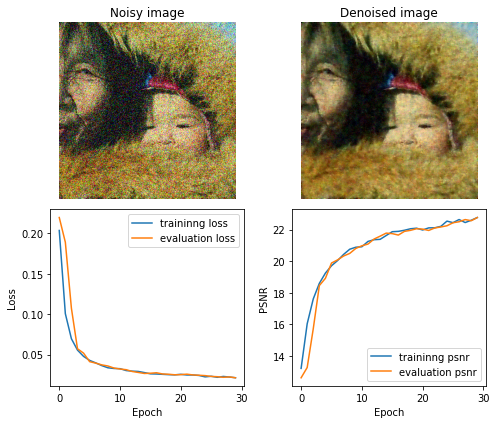

In [10]:
def plot(exp, fig, axes, noisy, visu_rate=3):
    if exp.epoch % visu_rate != 0:
        return 
    with torch.no_grad():
        denoised = exp.net(noisy[np.newaxis].to(exp.net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy image')
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised image')    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="traininng loss")
    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="traininng psnr")
    axes[1][0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)], label="evaluation loss")
    axes[1][1].plot([exp.history[k][1]['psnr'] for k in range(exp.epoch)], label="evaluation psnr")
    axes[1][0].legend()
    axes[1][0].set_xlabel("Epoch")
    axes[1][0].set_ylabel("Loss")        
    axes[1][1].legend()
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("PSNR")    
    plt.tight_layout()
    fig.canvas.draw()
    
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6))
exp1.run(num_epochs=30, plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=test_set[1][0]))

### Question 7
Compare the noisy, clean and denoised results on a few images of the testing set. Evaluate the visual quality of your result.
Do you see any artifacts or loss of information?


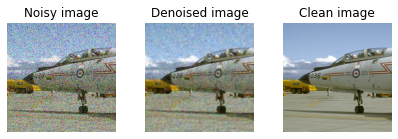

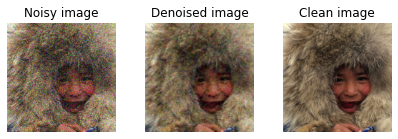

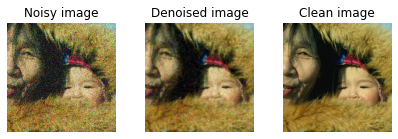

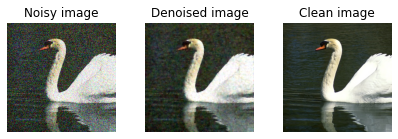

In [11]:
test_loader = td.DataLoader(test_set, batch_size=B, shuffle=True,
                            drop_last=True, pin_memory=True)
_, sample = next(enumerate(test_loader))
noisy, clean = sample
clean = clean.to(device)
noisy = noisy.to(device)
with torch.no_grad():
    denoised = dncnn(noisy)
for k in range(clean.shape[0]):
    fig, axis = plt.subplots(ncols=3, figsize=(7,2), sharex='all', sharey='all')
    myimshow(noisy[k], ax=axis[0])
    axis[0].set_title('Noisy image')
    myimshow(denoised[k], ax=axis[1])
    axis[1].set_title('Denoised image')
    myimshow(clean[k], ax=axis[2])
    axis[2].set_title('Clean image')
    plt.show()

### Question 8
What is the number of parameters of DnCNN(D)? What is the receptive field of DnCNN(D), i.e,how many input pixels do influence an output pixel?

Denoising literature claims that for reducing Gaussian noise of standard
  deviation $\sigma=30$ efficiently, a pixel should be influenced by
  at least $33 \times 33$ pixels. How large $D$ (how deep) should
  DnCNN be to satisfy this constraint? What would be the implication on
  the number of parameters and the computation time?



In [12]:
#To see the number of parameters of every layers of the network
for p in dncnn.parameters():
    print(p.numel())

1728
64
36864
64
36864
64
36864
64
36864
64
36864
64
36864
64
1728
3
64
64
64
64
64
64
64
64
64
64
64
64


## 3 U-net like CNNs
Pooling layers allows us to increase the receptive field (i.e. the region in the input space that a particular CNN's feature is looking)
without making the network deeper and slower. But
pooling layers lose spatial resolution.
In order to retrieve the spatial dimension we will have to use unpooling.
Our architecture will resemble the so-called U-net architecture
(that was originally introduced for image segmentation).
Our network will consist of a contracting path and an expansive path,
which gives it the U-shaped architecture. The contracting path is
a typical convolutional network that consists of repeated application
of convolutions, ReLU and max pooling operation. During the contraction,
the spatial information is reduced.
The expansive pathway reconstructs spatial information through a sequence of
unpooling and convolutions (note that if we were using strided convolutions, we
would have to use transpose convolutions), and combined
high-resolution features from the contracting path.
In the original U-net, features were combined by concatenating the channels
of the tensors, but here we will consider their sum divided by $\sqrt{2}$
(this is to preserve the range of feature variations).
The architecture is summarized in the following scheme. 



![DnCNN](./udncnn.jpg)

### Question 9
Complete the following code to implement this architecture.

In [12]:
class UDnCNN(NNRegression):

    def __init__(self, D, C=64):
        super(UDnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3,C,3, padding = 1))
        for k in range(int(D/2)-1):
            self.conv.append(nn.Conv2d(C,C,3, padding = 1))
        self.conv.append(nn.Conv2d(C,C,3, padding = 1))
        self.conv.append(nn.Conv2d(C,C,3, padding = 1))
        for k in range(int(D/2)+1,D):
            self.conv.append(nn.Conv2d(C,C,3, padding = 1))
        self.conv.append(nn.Conv2d(C,3,3, padding = 1))
        
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C))
            
        self.max_poold2d = nn.MaxPool2d(2,2)
        self.max_unpool2D = nn.MaxUnpool2d(2,2)
        
        
 #def __init__(self, D, C=64, apply_init=True):
  #      super(DnCNN, self).__init__()
   #     self.D = D
    #    self.conv = nn.ModuleList()
     #   self.conv.append(nn.Conv2d(3, C, 3, padding=1)) #!COMPLETE
      #  for k in range(D):
       #     self.conv.append(nn.Conv2d(C,C,3, padding=1))#!COMPLETE
        #self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        #self.bn = nn.ModuleList()
        #for k in range(D):
        #    self.bn.append(nn.BatchNorm2d(C))

    def forward(self, x):
        D = self.D
        
        h = [None] * int(D + 1)
        i = [None] * int(D/2-1)
        s = [None] * int(D/2-1)
        
        h[0] = F.relu(self.conv[0](x))
        
        for k in range(int(D/2)-1):
            h[k+1] = F.relu(self.bn[k](self.conv[k+1](h[k])))  #!COMPLETE
            s[k] = h[k+1].shape #needed for unpool layers
            h[k+1], i[k] = F.max_pool2d(h[k+1], (2,2), return_indices=True)
        
        k = int(D/2) - 1
        h[k+1] = F.relu(self.bn[k](self.conv[k+1](h[k]))) #!COMPLETE
        k = int(D/2)
        
        h[k+1] = F.relu(self.bn[k](self.conv[k+1](h[k]))) #!COMPLETE
        h[k+1] = (h[k+1] + h[k-1]) / np.sqrt(2)
        
        for k in range(int(D/2)+1, D):
            l = D - k - 1
            h[k] = F.max_unpool2d(h[k], i[l], (2,2), output_size=s[l])
            h[k+1] = F.relu(self.bn[k](self.conv[k+1](h[k]))) #!COMPLETE
            h[k+1] = (h[k+1] + h[l]) / np.sqrt(2)
        y = self.conv[D + 1](h[D]) + x
        return y

### Question 10
Test it this architecture and analyze the results.

Start/Continue training from epoch 0
Epoch 1 (Time: 1.34s)
Epoch 2 (Time: 1.42s)
Epoch 3 (Time: 1.35s)
Epoch 4 (Time: 1.29s)
Epoch 5 (Time: 1.26s)
Epoch 6 (Time: 1.39s)
Epoch 7 (Time: 1.16s)
Epoch 8 (Time: 1.32s)
Epoch 9 (Time: 1.17s)
Epoch 10 (Time: 1.26s)
Epoch 11 (Time: 1.24s)
Epoch 12 (Time: 1.33s)
Epoch 13 (Time: 1.42s)
Epoch 14 (Time: 1.52s)
Epoch 15 (Time: 1.44s)
Epoch 16 (Time: 1.48s)
Epoch 17 (Time: 1.38s)
Epoch 18 (Time: 1.36s)
Epoch 19 (Time: 1.36s)
Epoch 20 (Time: 1.32s)
Epoch 21 (Time: 1.37s)
Epoch 22 (Time: 1.36s)
Epoch 23 (Time: 1.43s)
Epoch 24 (Time: 1.41s)
Epoch 25 (Time: 1.41s)
Epoch 26 (Time: 1.45s)
Epoch 27 (Time: 1.40s)
Epoch 28 (Time: 1.44s)
Epoch 29 (Time: 1.38s)
Epoch 30 (Time: 1.37s)
Finish training for 30 epochs


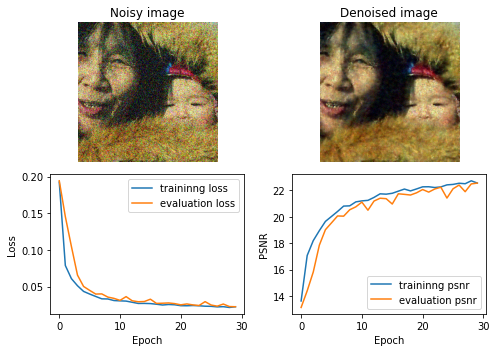

In [13]:

B = 4
D = 6
lr = 1e-3
udncnn = UDnCNN(D)
udncnn = udncnn.to(device)
adam = torch.optim.Adam(udncnn.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
 #!COMPLETE
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,5))
exp2 = nt.Experiment(udncnn, train_set, val_set, adam, stats_manager, batch_size=B,
                     output_dir="denoising2", perform_validation_during_training=True)
exp2.run(num_epochs=30, plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=test_set[1][0]))

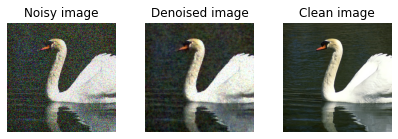

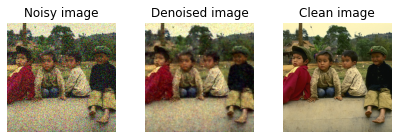

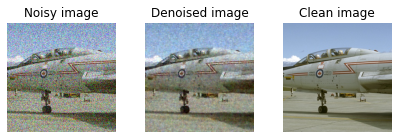

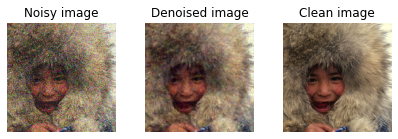

In [14]:
test_loader = td.DataLoader(test_set, batch_size=B, shuffle=True,
                            drop_last=True, pin_memory=True)
_, sample = next(enumerate(test_loader))
noisy, clean = sample
clean = clean.to(device)
noisy = noisy.to(device)
with torch.no_grad():
    denoised = udncnn(noisy)
for k in range(clean.shape[0]):
    fig, axis = plt.subplots(ncols=3, figsize=(7,2), sharex='all', sharey='all')
    myimshow(noisy[k], ax=axis[0])
    axis[0].set_title('Noisy image')
    myimshow(denoised[k], ax=axis[1])
    axis[1].set_title('Denoised image')
    myimshow(clean[k], ax=axis[2])
    axis[2].set_title('Clean image')
    plt.show()

### Question 11
What is its number of parameters and the receptive field ?


_Note_ : Though pooling layers
increase the receptive field, they lose information about exact locations.
This is desired for classification, but for denoising this decreases performance.
An alternative to pooling is to use dilated convolutions
(sometimes refer to the a trous algorithm, meaning with holes).
Instead of increasing the receptive field by reducing the feature spatial
dimensions by a factor 2 after each convolution, the filters are dilated
by a factor 2. 

In [15]:
for p in udncnn.parameters():
    print(p.numel())

1728
64
36864
64
36864
64
36864
64
36864
64
36864
64
36864
64
1728
3
64
64
64
64
64
64
64
64
64
64
64
64


### Question 12
Other validation metrics can be used in image processing? Can present one of them and test it on your results?